<a href="https://colab.research.google.com/github/DrKenReid/VAE-for-Molecule-Discovery/blob/main/Variational_Autoencoder_for_Molecule_Discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder for Molecule Discovery

This tutorial demonstrates how to use a Variational Autoencoder (VAE) for generating novel molecular structures. This approach is particularly useful in drug discovery, where we aim to generate new potential drug candidates.

**Click runtime -> change runtime type -> GPU**

1. Setting Up the Environment:
We'll use PyTorch for deep learning and RDKit for cheminformatics. PyTorch is chosen for its flexibility and ease of use, while RDKit is an industry-standard tool for handling molecular data.

In [1]:
!pip install rdkit torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
import pandas as pd


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

2. Data Preparation: We use the QM9 dataset, a standard benchmark in molecular machine learning. It contains about 134,000 small organic molecules.

In [2]:
def load_qm9_dataset(url: str = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv") -> pd.DataFrame:
    """
    Download and load the QM9 dataset.

    This function downloads the QM9 dataset from the specified URL using wget,
    then loads it into a pandas DataFrame. It extracts the SMILES strings
    from the DataFrame for further processing.

    Args:
        url (str): The URL of the QM9 dataset CSV file.
                   Defaults to the DeepChem hosted QM9 dataset.

    Returns:
        pd.DataFrame: The loaded QM9 dataset as a pandas DataFrame.

    Raises:
        subprocess.CalledProcessError: If the wget command fails.
        pd.errors.EmptyDataError: If the CSV file is empty or cannot be read.

    Note:
        This function requires wget to be installed and accessible in the system path.
        It saves the downloaded file as 'qm9.csv' in the current directory.
    """
    import subprocess

    # Download the QM9 dataset
    try:
        subprocess.run(['wget', url], check=True)
        print(f"Dataset downloaded successfully from {url}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to download dataset: {e}")
        raise

    # Load the dataset
    try:
        df = pd.read_csv('qm9.csv')
        print(f"Loaded QM9 dataset with {len(df)} entries")
        return df
    except pd.errors.EmptyDataError:
        print("The CSV file is empty or could not be read")
        raise

# go
df = load_qm9_dataset()
smiles_list = df['smiles'].tolist()
print(f"Extracted {len(smiles_list)} SMILES strings from the dataset")

Dataset downloaded successfully from https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv
Loaded QM9 dataset with 133885 entries
Extracted 133885 SMILES strings from the dataset


Creating a Vocabulary: we create a vocabulary from the SMILES strings. This allows us to represent molecules as sequences of tokens that our model can process.

In [3]:
from typing import List, Dict

def create_vocabulary(smiles_list: List[str]) -> Dict[str, int]:
    """
    Create a vocabulary mapping from SMILES characters to integer indices.

    This function generates a vocabulary dictionary from a list of SMILES strings.
    It includes special tokens for start ('<') and end ('>') of sequences, and
    assigns a unique integer index to each unique character found in the SMILES strings.

    Args:
        smiles_list (List[str]): A list of SMILES strings to create the vocabulary from.

    Returns:
        Dict[str, int]: A dictionary mapping characters to their corresponding integer indices.

    Example:
        >>> smiles_list = ['CC(=O)OC1=CC=CC=C1C(=O)O', 'C1=CC=C(C=C1)C(=O)O']
        >>> vocab = create_vocabulary(smiles_list)
        >>> print(vocab)
        {'<': 0, '>': 1, 'C': 2, '(': 3, '=': 4, 'O': 5, ')': 6, '1': 7}

    Note:
        The returned vocabulary will always include '<' and '>' as the first two entries,
        representing start and end tokens respectively.
    """
    vocab = {'<': 0, '>': 1}  # Start and end tokens
    for smiles in smiles_list:
        for char in smiles:
            if char not in vocab:
                vocab[char] = len(vocab)
    return vocab

vocab = create_vocabulary(smiles_list)

3. Dataset Creation: We create a custom dataset that converts SMILES strings into one-hot encoded tensors. This representation allows the model to process the molecular data efficiently.

In [4]:
class SMILESDataset(Dataset):
    """
    A PyTorch Dataset for SMILES strings.

    This dataset converts SMILES strings into one-hot encoded tensors based on a given vocabulary.
    It adds start ('<') and end ('>') tokens to each SMILES string before encoding.

    Attributes:
        smiles_list (List[str]): A list of SMILES strings.
        vocab (Dict[str, int]): A dictionary mapping characters to their corresponding indices.
        vocab_size (int): The size of the vocabulary.

    """

    def __init__(self, smiles_list: List[str], vocab: Dict[str, int], max_length: int = 100):
        """
        Initialize the SMILESDataset.

        Args:
            smiles_list (List[str]): A list of SMILES strings to be encoded.
            vocab (Dict[str, int]): A dictionary mapping characters to their corresponding indices.
        """
        self.smiles_list = smiles_list
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.max_length = max_length

    def __len__(self) -> int:
        """
        Get the number of items in the dataset.

        Returns:
            int: The number of SMILES strings in the dataset.
        """
        return len(self.smiles_list)

    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        Get a one-hot encoded tensor for a SMILES string at the given index.

        Args:
            idx (int): The index of the SMILES string to retrieve.

        Returns:
            torch.Tensor: A one-hot encoded tensor representing the SMILES string.
                          Shape: (len(smiles), vocab_size)

        Note:
            Start ('<') and end ('>') tokens are added to the SMILES string before encoding.
            If a character in the SMILES string is not in the vocabulary, it is encoded as the first token (index 0).
        """

        smiles = '<' + self.smiles_list[idx] + '>'
        encoded = torch.zeros(self.max_length, self.vocab_size)
        for i, c in enumerate(smiles[:self.max_length]):
            encoded[i, self.vocab.get(c, 0)] = 1
        return encoded

4. Model Architecture: We use a VAE architecture, which consists of an encoder, a latent space, and a decoder. This architecture is chosen because it can learn a compact representation of the input data and generate new samples from this representation.

In [5]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) for SMILES string generation.

    This VAE encodes SMILES strings into a latent space and decodes latent
    vectors back into SMILES strings. It uses GRU layers for both encoding and decoding.

    Attributes:
        vocab_size (int): Size of the SMILES vocabulary.
        hidden_dim (int): Dimension of the hidden state in GRU layers.
        latent_dim (int): Dimension of the latent space.
        encoder (nn.GRU): GRU layer for encoding input sequences.
        fc_mu (nn.Linear): Fully connected layer for mean of latent space.
        fc_logvar (nn.Linear): Fully connected layer for log variance of latent space.
        decoder (nn.GRU): GRU layer for decoding latent vectors.
        fc_output (nn.Linear): Fully connected layer for output probabilities.
    """

    def __init__(self, vocab_size: int, hidden_dim: int, latent_dim: int):
        """
        Initialize the VAE model.

        Args:
            vocab_size (int): Size of the SMILES vocabulary.
            hidden_dim (int): Dimension of the hidden state in GRU layers.
            latent_dim (int): Dimension of the latent space.
        """
        super(VAE, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = nn.GRU(vocab_size, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.GRU(vocab_size + latent_dim, hidden_dim, batch_first=True)
        self.fc_output = nn.Linear(hidden_dim, vocab_size)

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Encode input sequences into the latent space.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, vocab_size).

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Mean and log variance of the latent space distribution.
        """
        _, h = self.encoder(x)
        h = h.squeeze(0)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Perform the reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent space distribution.
            logvar (torch.Tensor): Log variance of the latent space distribution.

        Returns:
            torch.Tensor: Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor, max_length: int) -> torch.Tensor:
        """
        Decode latent vectors into sequences.

        Args:
            z (torch.Tensor): Latent vector of shape (batch_size, latent_dim).
            max_length (int): Maximum length of the generated sequence.

        Returns:
            torch.Tensor: Decoded sequences of shape (batch_size, max_length, vocab_size).
        """
        batch_size = z.size(0)
        h = torch.zeros(1, batch_size, self.hidden_dim).to(z.device)
        x = torch.zeros(batch_size, 1, self.vocab_size).to(z.device)
        outputs = []

        for _ in range(max_length):
            z_input = z.unsqueeze(1).repeat(1, 1, 1)
            decoder_input = torch.cat([x, z_input], dim=2)
            output, h = self.decoder(decoder_input, h)
            output = self.fc_output(output)
            outputs.append(output)
            x = torch.softmax(output, dim=-1)

        return torch.cat(outputs, dim=1)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass through the VAE.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, vocab_size).

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
                - Reconstructed input of shape (batch_size, seq_len, vocab_size)
                - Mean of the latent space distribution
                - Log variance of the latent space distribution
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, x.size(1)), mu, logvar

5. Training the Model: We train the model using a combination of reconstruction loss (binary [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy)) and [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os

def loss_function(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    BCE = nn.functional.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + 0.1 * KLD

def custom_collate(batch):
    return torch.stack(batch)

# Determine the number of workers based on system resources
num_workers = min(2, os.cpu_count() or 1)

# DataLoader setup
batch_size = 128
dataset = SMILESDataset(smiles_list, vocab, max_length=100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate,
                        num_workers=num_workers, pin_memory=True)

# Model initialization
vocab_size = len(vocab)
hidden_dim = 256
latent_dim = 64

model = VAE(vocab_size, hidden_dim, latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Initialize mixed precision training if CUDA is available
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        # Use autocast only if CUDA is available
        with torch.cuda.amp.autocast(enabled=use_amp):
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar)

        # Backward pass and optimization with gradient scaling if CUDA is available
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    # Print epoch results
    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

    # Update learning rate
    scheduler.step(avg_loss)

    # Print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')

print("Training complete!")

Epoch 1, Average Loss: 97.0341
Current learning rate: 0.001000
Epoch 2, Average Loss: 48.1049
Current learning rate: 0.001000
Epoch 3, Average Loss: 42.9307
Current learning rate: 0.001000
Training complete!


6. Generating New Molecules: After training, we use the decoder to generate new molecular structures.

In [7]:
def generate_smiles(model: torch.nn.Module, vocab: Dict[str, int], num_samples: int = 10, max_length: int = 100) -> List[str]:
    """
    Generate SMILES strings using the trained VAE model.

    This function generates a specified number of SMILES strings by sampling from the
    latent space and decoding the samples using the VAE's decoder.

    Args:
        model (torch.nn.Module): The trained VAE model.
        vocab (Dict[str, int]): The vocabulary mapping characters to indices.
        num_samples (int, optional): Number of SMILES strings to generate. Defaults to 10.
        max_length (int, optional): Maximum length of generated SMILES strings. Defaults to 100.

    Returns:
        List[str]: A list of generated SMILES strings.

    Note:
        - The function uses greedy decoding (taking the most probable character at each step).
        - Generation stops when the end token '>' is produced or max_length is reached.
        - Invalid characters (not in vocabulary) are ignored in the output.
    """
    model.eval()  # Set the model to evaluation mode
    inv_vocab = {v: k for k, v in vocab.items()}  # Invert vocabulary for decoding
    generated_smiles = []
    device = next(model.parameters()).device  # Get the device of the model

    with torch.no_grad():  # Disable gradient computation
        for _ in range(num_samples):
            # Sample from the latent space
            z = torch.randn(1, model.latent_dim).to(device)
            x = torch.zeros(1, 1, model.vocab_size).to(device)
            x[0, 0, vocab['<']] = 1  # Start token
            h = torch.zeros(1, 1, model.hidden_dim).to(device)

            smiles = ''
            for _ in range(max_length):
                z_input = z.unsqueeze(1)
                decoder_input = torch.cat([x, z_input], dim=2)
                output, h = model.decoder(decoder_input, h)
                output = model.fc_output(output)

                probs = torch.softmax(output.squeeze(0), dim=-1)
                next_char = torch.multinomial(probs, 1).item()

                if next_char == vocab['>']:  # End token
                    break

                smiles += inv_vocab.get(next_char, '')
                x = torch.zeros(1, 1, model.vocab_size).to(device)
                x[0, 0, next_char] = 1

            generated_smiles.append(smiles)

    return generated_smiles

# Generate and print some SMILES strings
num_samples = 10
generated_smiles = generate_smiles(model, vocab, num_samples=num_samples)
print(f"Generated {num_samples} SMILES strings:")
for i, smiles in enumerate(generated_smiles, 1):
    print(f"{i}. {smiles}")

Generated 10 SMILES strings:
1. <C1CO1C11#1
2. <CO1CCCCCC=1O1
3. FO54
4. 
5. <CC111CC2COCCCC2C
6. +=N(CC32CCCC1
7. )N11=24CC12C2
8. ]N4+F
9. 3(C#=NCCC1CCCC
10. <C1CCC2((C)C1==C


7. Analyzing Generated Molecules: After generating new molecules, we analyze them for validity, novelty, and potential usefulness. Here are some common analyses and insights we can derive:

  7.1 Validity Check: First, we'll check how many of our generated SMILES strings represent valid molecules:

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from typing import Tuple, List, Dict

def validate_and_correct_smiles(smiles: str) -> Tuple[bool, str]:
    """
    Validate and attempt to correct a SMILES string.

    Args:
        smiles (str): The SMILES string to validate and correct.

    Returns:
        Tuple[bool, str]: A tuple containing a boolean indicating validity
                          and the corrected SMILES string (or original if invalid).
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        try:
            Chem.SanitizeMol(mol)
            return True, Chem.MolToSmiles(mol, isomericSmiles=True)
        except:
            pass
    return False, smiles

def enhanced_post_process_smiles(smiles: str) -> str:
    """
    Post-process a SMILES string to correct common issues.

    Args:
        smiles (str): The SMILES string to process.

    Returns:
        str: The processed SMILES string.
    """
    smiles = smiles.replace('<', '').replace('>', '')
    allowed_chars = set('CNOPSFIBrClcnops()[]=@+-#0123456789')
    smiles = ''.join(c for c in smiles if c in allowed_chars)

    # Balance parentheses
    open_count = smiles.count('(')
    close_count = smiles.count(')')
    if open_count > close_count:
        smiles += ')' * (open_count - close_count)
    elif close_count > open_count:
        smiles = '(' * (close_count - open_count) + smiles

    # Replace invalid double bonds
    smiles = smiles.replace('==', '=')

    # Attempt to close unclosed rings
    for i in range(1, 10):
        if smiles.count(str(i)) % 2 != 0:
            smiles += str(i)

    return smiles

def analyze_molecules(smiles_list: List[str]) -> Dict:
    """
    Analyze a list of SMILES strings and provide detailed statistics.

    Args:
        smiles_list (List[str]): A list of SMILES strings to analyze.

    Returns:
        Dict: A dictionary containing various statistics and analyses.
    """
    results = {
        'total': len(smiles_list),
        'valid': 0,
        'invalid': 0,
        'unique': 0,
        'corrected': 0,
        'properties': [],
        'invalid_smiles': []
    }

    unique_smiles = set()

    for smiles in smiles_list:
        processed_smiles = enhanced_post_process_smiles(smiles)
        is_valid, corrected_smiles = validate_and_correct_smiles(processed_smiles)

        if is_valid:
            results['valid'] += 1
            unique_smiles.add(corrected_smiles)
            if corrected_smiles != processed_smiles:
                results['corrected'] += 1

            mol = Chem.MolFromSmiles(corrected_smiles)
            results['properties'].append({
                'smiles': corrected_smiles,
                'molecular_weight': Descriptors.ExactMolWt(mol),
                'logp': Descriptors.MolLogP(mol),
                'num_atoms': mol.GetNumAtoms(),
                'num_rings': Descriptors.RingCount(mol)
            })
        else:
            results['invalid'] += 1
            results['invalid_smiles'].append(smiles)

    results['unique'] = len(unique_smiles)
    return results

# Assume generated_smiles is your list of generated SMILES strings
analysis = analyze_molecules(generated_smiles)

# Print summary
print(f"Total SMILES: {analysis['total']}")
print(f"Valid SMILES: {analysis['valid']} ({analysis['valid']/analysis['total']:.2%})")
print(f"Invalid SMILES: {analysis['invalid']} ({analysis['invalid']/analysis['total']:.2%})")
print(f"Unique SMILES: {analysis['unique']} ({analysis['unique']/analysis['total']:.2%})")
print(f"Corrected SMILES: {analysis['corrected']} ({analysis['corrected']/analysis['total']:.2%})")

# Print property statistics
df = pd.DataFrame(analysis['properties'])
print("\nProperty Statistics:")
print(df.describe())

# Print some invalid SMILES
print("\nSample of Invalid SMILES:")
for smiles in analysis['invalid_smiles'][:5]:  # Print first 5 invalid SMILES
    print(smiles)

# Optionally, save the full analysis to a CSV file
df.to_csv('molecule_properties.csv', index=False)
print("\nFull property analysis saved to 'molecule_properties.csv'")

Total SMILES: 10
Valid SMILES: 1 (10.00%)
Invalid SMILES: 9 (90.00%)
Unique SMILES: 1 (10.00%)
Corrected SMILES: 0 (0.00%)

Property Statistics:
       molecular_weight  logp  num_atoms  num_rings
count               1.0   1.0        1.0        1.0
mean                0.0   0.0        0.0        0.0
std                 NaN   NaN        NaN        NaN
min                 0.0   0.0        0.0        0.0
25%                 0.0   0.0        0.0        0.0
50%                 0.0   0.0        0.0        0.0
75%                 0.0   0.0        0.0        0.0
max                 0.0   0.0        0.0        0.0

Sample of Invalid SMILES:
<C1CO1C11#1
<CO1CCCCCC=1O1
FO54
<CC111CC2COCCCC2C
+=N(CC32CCCC1

Full property analysis saved to 'molecule_properties.csv'


[14:02:32] SMILES Parse Error: duplicated ring closure 1 bonds atom 3 to itself for input: 'C1CO1C11#11'
[14:02:32] SMILES Parse Error: duplicated ring closure 1 bonds atom 8 to itself for input: 'CO1CCCCCC=1O11'
[14:02:32] SMILES Parse Error: duplicated ring closure 4 bonds atom 1 to itself for input: 'FO5445'
[14:02:32] SMILES Parse Error: duplicated ring closure 1 bonds atom 1 to itself for input: 'CC111CC2COCCCC2C1'
[14:02:32] SMILES Parse Error: syntax error while parsing: +=N(CC32CCCC1)123
[14:02:32] SMILES Parse Error: Failed parsing SMILES '+=N(CC32CCCC1)123' for input: '+=N(CC32CCCC1)123'
[14:02:32] SMILES Parse Error: syntax error while parsing: ()N11=24CC12C2124
[14:02:32] SMILES Parse Error: Failed parsing SMILES '()N11=24CC12C2124' for input: '()N11=24CC12C2124'
[14:02:32] SMILES Parse Error: syntax error while parsing: ]N4+F4
[14:02:32] SMILES Parse Error: Failed parsing SMILES ']N4+F4' for input: ']N4+F4'
[14:02:32] SMILES Parse Error: syntax error while parsing: 3(C#=NC

7.2 Novelty Assessment
We can check if our generated molecules are novel (not present in the training set):

In [10]:
from typing import List, Set

def check_novelty(generated_smiles: List[str], training_smiles: Set[str]) -> tuple[List[str], float]:
    """
    Check the novelty of generated SMILES strings against a training set.

    This function determines which of the generated SMILES strings are not present
    in the training set, and calculates the novelty rate.

    Args:
        generated_smiles (List[str]): A list of SMILES strings generated by the model.
        training_smiles (Set[str]): A set of SMILES strings used for training the model.

    Returns:
        tuple[List[str], float]: A tuple containing:
            - A list of novel SMILES strings (those not in the training set).
            - The novelty rate as a float (proportion of novel SMILES).

    Example:
        >>> training_set = {"CC", "CCO", "CCCC"}
        >>> generated_smiles = ["CC", "CCC", "CCCO", "CCO"]
        >>> novel, rate = check_novelty(generated_smiles, training_set)
        >>> print(novel)
        ['CCC', 'CCCO']
        >>> print(f"Novelty rate: {rate:.2%}")
        Novelty rate: 50.00%
    """
    novel_molecules = [s for s in generated_smiles if s not in training_smiles]
    novelty_rate = len(novel_molecules) / len(generated_smiles)
    return novel_molecules, novelty_rate

training_set = set(smiles_list)  # Convert training list to a set for faster lookup
novel_molecules, novelty_rate = check_novelty(generated_smiles, training_set)

print(f"Novelty rate: {novelty_rate:.2%}")
print(f"Number of novel molecules: {len(novel_molecules)}")
print("\nSample of novel molecules:")
for smiles in novel_molecules[:5]:  # Print first 5 novel SMILES
    print(smiles)

Novelty rate: 100.00%
Number of novel molecules: 10

Sample of novel molecules:
<C1CO1C11#1
<CO1CCCCCC=1O1
FO54

<CC111CC2COCCCC2C


7.3 Basic Property Calculation: We can calculate some basic molecular properties for valid molecules:

In [11]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from typing import List, Dict, Optional

def calculate_properties(smiles: str) -> Optional[Dict[str, float]]:
    """
    Calculate molecular properties for a given SMILES string.

    This function computes several key molecular properties using RDKit's Descriptors module.
    If the SMILES string is invalid or cannot be converted to a molecule, the function returns None.

    Args:
        smiles (str): A SMILES string representing a molecule.

    Returns:
        Optional[Dict[str, float]]: A dictionary containing the calculated properties, or None if the SMILES is invalid.
        The dictionary includes the following properties:
            - 'MolWt': Exact molecular weight
            - 'LogP': Octanol-water partition coefficient
            - 'NumHDonors': Number of hydrogen bond donors
            - 'NumHAcceptors': Number of hydrogen bond acceptors

    Example:
        >>> props = calculate_properties("CCO")
        >>> print(props)
        {'MolWt': 46.06844, 'LogP': -0.0014, 'NumHDonors': 1, 'NumHAcceptors': 1}
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return {
            'MolWt': Descriptors.ExactMolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol)
        }
    return None

def calculate_properties_for_valid_mols(generated_smiles: List[str]) -> List[Optional[Dict[str, float]]]:
    """
    Calculate properties for a list of generated SMILES strings, considering only valid molecules.

    This function iterates through the list of generated SMILES strings, calculates properties
    for valid molecules, and returns a list of property dictionaries.

    Args:
        generated_smiles (List[str]): A list of SMILES strings generated by the model.

    Returns:
        List[Optional[Dict[str, float]]]: A list of dictionaries containing calculated properties
        for valid molecules. Invalid SMILES strings are excluded from the result.

    Example:
        >>> smiles_list = ["CCO", "InvalidSMILES", "C1=CC=CC=C1"]
        >>> properties_list = calculate_properties_for_valid_mols(smiles_list)
        >>> print(len(properties_list))
        2
    """
    return [calculate_properties(s) for s in generated_smiles if Chem.MolFromSmiles(s)]

valid_mols_properties = calculate_properties_for_valid_mols(smiles)

print(f"Number of valid molecules: {len(valid_mols_properties)}")
for i, props in enumerate(valid_mols_properties, 1):
    if props:
        print(f"Molecule {i}:")
        for key, value in props.items():
            print(f"  {key}: {value}")
        print()

Number of valid molecules: 11
Molecule 1:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 2:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 3:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 4:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 5:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 6:
  MolWt: 18.010564684
  LogP: -0.8247
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 7:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 8:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 9:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 10:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDonors: 0
  NumHAcceptors: 0

Molecule 11:
  MolWt: 16.031300127999998
  LogP: 0.6361
  NumHDo

[14:02:37] SMILES Parse Error: syntax error while parsing: <
[14:02:37] SMILES Parse Error: Failed parsing SMILES '<' for input: '<'
[14:02:37] SMILES Parse Error: syntax error while parsing: 1
[14:02:37] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[14:02:37] SMILES Parse Error: syntax error while parsing: 1
[14:02:37] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[14:02:37] SMILES Parse Error: syntax error while parsing: 1
[14:02:37] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[14:02:37] SMILES Parse Error: syntax error while parsing: 2
[14:02:37] SMILES Parse Error: Failed parsing SMILES '2' for input: '2'
[14:02:37] SMILES Parse Error: syntax error while parsing: 2
[14:02:37] SMILES Parse Error: Failed parsing SMILES '2' for input: '2'


7.4 Visualizing Generated Molecules: We can visualize some of the valid generated molecules:

[14:16:39] SMILES Parse Error: syntax error while parsing: 1
[14:16:39] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[14:16:39] SMILES Parse Error: syntax error while parsing: 1
[14:16:39] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[14:16:39] SMILES Parse Error: syntax error while parsing: 1
[14:16:39] SMILES Parse Error: Failed parsing SMILES '1' for input: '1'
[14:16:39] SMILES Parse Error: syntax error while parsing: 2
[14:16:39] SMILES Parse Error: Failed parsing SMILES '2' for input: '2'


5 molecules not drawn due to invalidity. Drawing 5 molecules...
Visualization of generated molecules successful. Image saved as: generated_molecules.png


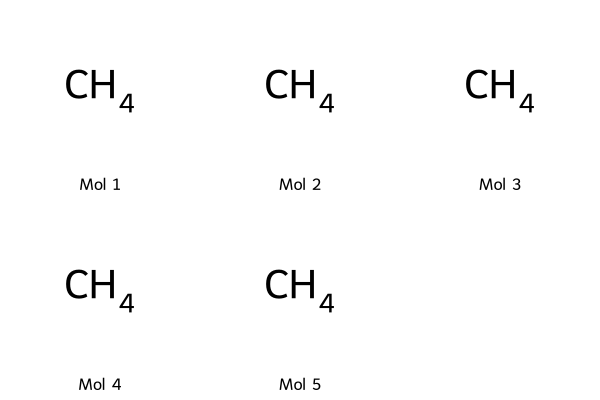

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw
from typing import List, Optional, Tuple
import logging
from PIL import Image
import io
from IPython.display import display

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def visualize_molecules(smiles_list: List[str], n: int = 5, filename: str = "generated_molecules.png") -> Optional[Tuple[str, Image.Image]]:
    """
    Visualize a list of generated molecules from their SMILES strings, save and return the image.

    This function takes the list of generated SMILES strings, converts them to RDKit molecule objects,
    generates a grid image of the molecules, and both saves and returns the image.

    Args:
        smiles_list (List[str]): The list of generated SMILES strings to visualize.
        n (int, optional): Maximum number of molecules to visualize. Defaults to 5.
        filename (str, optional): Name of the file to save the image. Defaults to "generated_molecules.png".

    Returns:
        Optional[Tuple[str, Image.Image]]: A tuple containing the filename of the saved image and the Image object if successful, None otherwise.

    Raises:
        ValueError: If no valid molecules are found in the input list.
    """
    valid_mols = []
    invalid_count = 0
    for i, smiles in enumerate(smiles_list):
        # Remove any start/end tokens and whitespace
        smiles = smiles.strip().strip('<>').strip()
        if not smiles:  # Skip empty strings
            invalid_count += 1
            continue
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_mols.append(mol)
                if len(valid_mols) == n:
                    break
            else:
                logger.warning(f"Invalid SMILES at index {i}: {smiles}")
                invalid_count += 1
        except Exception as e:
            logger.error(f"Error processing SMILES at index {i}: {smiles}. Error: {str(e)}")
            invalid_count += 1

    if not valid_mols:
        logger.error("No valid molecules found in the generated SMILES list.")
        return None

    print(f"{invalid_count} molecules not drawn due to invalidity. Drawing {len(valid_mols)} molecules...")

    try:
        img = Draw.MolsToGridImage(
            valid_mols,
            molsPerRow=min(3, len(valid_mols)),
            subImgSize=(200, 200),
            legends=[f"Mol {i+1}" for i in range(len(valid_mols))]
        )
        # Convert the RDKit image to a PIL Image
        img_pil = Image.open(io.BytesIO(img.data))
        img_pil.save(filename)
        logger.info(f"Generated molecule images saved as '{filename}'")
        return filename, img_pil
    except Exception as e:
        logger.error(f"Error saving generated molecule image: {str(e)}")
        return None

# The function call and display code
result = visualize_molecules(smiles)

if result:
    filename, img = result
    print(f"Visualization of generated molecules successful. Image saved as: {filename}")
    display(img)
else:
    print("Visualization of generated molecules failed.")

7.5 Insights and Discussion: After performing these analyses, we can discuss the results:

* Validity Rate: A high validity rate indicates that our model has learned to
 generate syntactically correct SMILES strings. However, if it's too high (close to 100%), it might suggest that the model is playing it safe and not exploring the chemical space enough.
* Novelty Rate: A high novelty rate suggests that our model is not just memorizing the training set but generating new structures. This is crucial for drug discovery applications.
* Property Distribution: By analyzing the distribution of molecular properties (like molecular weight, LogP, etc.), we can see if our generated molecules are similar to the training set or if they're exploring new areas of chemical space.
* Visual Inspection: Visualizing the molecules allows for a qualitative assessment of the types of structures being generated. This can help identify any patterns or biases in the generation process.
* Comparison to Training Set: We can compare the properties of generated molecules to those in the training set to see how well our model has captured the distribution of the original data.

These analyses provide insights into the performance of our VAE model and the characteristics of the generated molecules. They can guide further refinement of the model or selection of promising candidates for more detailed investigation in a drug discovery pipeline.

## Conclusion
This tutorial demonstrates how to use a VAE for molecular generation, combining deep learning techniques with chemical knowledge to create a tool for drug discovery. By understanding and modifying this code, biomedical researchers can adapt it to their specific research needs, potentially accelerating the drug discovery process.